# Practice Activity - Neural Networks

In [394]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, matthews_corrcoef, r2_score
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor

## Data Cleaning

In [247]:
data = pd.read_csv("/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,id,name,producer,nation,local1,local2,local3,local4,varieties1,varieties2,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Carmenere,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Merlot,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Cinsault,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Ugni​ blanc,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,NaN,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


Due to the large size of the data, I am going to programitically check which columns have large amounts of missing values. I will then drop those columns with more than 5% of the data. 

In [3]:
for var in data.columns:
    try:
        na_percent = data[var].isna().value_counts()[True] / data[var].isna().value_counts().sum()
        if na_percent > .05:
            print(f"Percent of NaN Values for {var}: {na_percent*100}")
    except KeyError:
        print(f"No missing values for {var}")

No missing values for id
No missing values for name
No missing values for producer
No missing values for nation
Percent of NaN Values for local2: 47.522378516624045
Percent of NaN Values for local3: 81.90537084398977
Percent of NaN Values for local4: 99.99200767263427
Percent of NaN Values for varieties2: 64.64194373401536
Percent of NaN Values for varieties3: 80.68254475703324
Percent of NaN Values for varieties4: 93.60613810741688
Percent of NaN Values for varieties5: 98.16975703324809
Percent of NaN Values for varieties6: 99.44053708439897
Percent of NaN Values for varieties7: 99.82416879795396
Percent of NaN Values for varieties8: 99.92007672634271
Percent of NaN Values for varieties9: 99.96803069053708
Percent of NaN Values for varieties10: 99.96803069053708
Percent of NaN Values for varieties11: 99.97602301790282
Percent of NaN Values for varieties12: 99.98401534526855
Percent of NaN Values for abv: 32.40888746803069
Percent of NaN Values for degree: 32.41687979539642
No missing 

Now I will clean the data by dropping the columns above, as well as id, name, and producer, as these are all identifying information that the model could link to each price. I also take the average of any abv and degree values that initially contained a tilda, as I believe these values being numeric is more valuable. 

In [4]:
def remove_tilda(value):
    if "~" in value:
        values = value.split("~")
        avg = (float(value[0]) + float(value[-1]))/2
        return avg
    else:
        return float(value)

In [271]:
clean_data = data.drop(
    ["id", "name", "producer", "local3", "local4", "varieties2",
     "varieties3", "varieties4", "varieties5", "varieties6", "varieties7",
     "varieties8", "varieties9", "varieties10", "varieties11", "varieties12"], axis = 1)
clean_data = clean_data[(clean_data["price"] != 0) & (clean_data["year"] != 0)]
clean_data = clean_data.dropna(axis = 0)
clean_data["year"] = clean_data["year"].astype(str)
clean_data["abv"] = clean_data["abv"].apply(lambda x: remove_tilda(x))
clean_data["degree"] = clean_data["degree"].apply(lambda x: remove_tilda(x))
clean_data.reset_index(inplace=True, drop=True)
clean_data

,nation,local1,local2,varieties1,type,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,France,Southern France,Languedoc Roussillon,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY2,TANNIN3,19000,2017,750
1,France,Southern France,Languedoc Roussillon,Merlot,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,19000,2011,750
2,France,Bordeaux,Premieres Cotes de Bordeaux,Semillon,White,Dessert,13.0,1.5,SWEET2,ACIDITY4,BODY3,TANNIN1,18000,2009,750
3,France,Bordeaux,Medoc,Cabernet Sauvignon,Red,Table,2.0,4.5,SWEET1,ACIDITY4,BODY3,TANNIN3,32000,2015,750
4,France,Bordeaux,SaintEmilion,Merlot,Red,Table,2.0,4.5,SWEET1,ACIDITY3,BODY2,TANNIN2,42000,2010,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,Italy,Toscana,Bolgheri,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,250000,2007,750
4017,USA,California,Riverside County,Sangiovese,Rose,"Appetizer, Table",2.5,4.0,SWEET2,ACIDITY3,BODY2,TANNIN1,195000,2013,750
4018,USA,California,Napa County,Cabernet Sauvignon,Red,Table,3.0,4.5,SWEET1,ACIDITY3,BODY4,TANNIN4,475000,2006,750
4019,the Republic of South Africa,Coastal Region,Paarl,Chardonnay,White,"Appetizer, Table",2.0,1.5,SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [25]:
# Due to some weird errors I have ended up column transforming outside of the pipeline, I don't know why these occurred but this seemed to solve the issue.
X = clean_data.drop("price", axis = 1)
X = ct.fit_transform(X)
y = clean_data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

## Neural Networks

In [22]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown="error", drop = "first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ]
)

Here is my first neural network. I have not set a regularization value and have built a small, 3 layer network. It has 16 total nodes in the hidden
layers and uses the relu activation function

In [278]:
# NN 1
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("nn", MLPRegressor(max_iter=5000, activation="relu", hidden_layer_sizes = (5, 6, 5, ), solver="lbfgs"))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

In [279]:
y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

-26.35155196306905

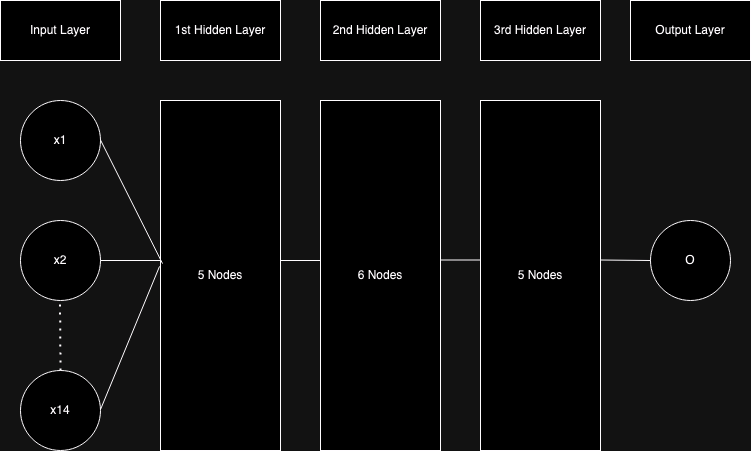

In this second network I change the activation function to tanh, greatly increase the number of nodes to 200 but decrease the number of layers, and introduce a regulization value.

In [280]:
# NN 2
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("nn", MLPRegressor(max_iter=5000, activation="tanh", hidden_layer_sizes = (200, ), solver="lbfgs", alpha = .9))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

In [281]:
y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

0.20075914867381228

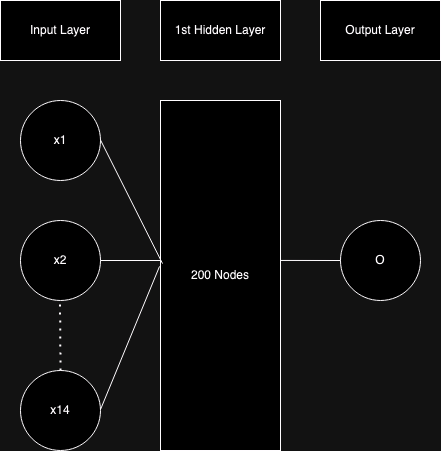

For the third neural network, I attempted to build on the success of the previous network by continuing to use the tanh activation function and further increasing the size of the neural network by introducing a second layer with an additional 400 nodes. This was unsuccesful unfortunately.

In [294]:
# NN 3
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("nn", MLPRegressor(max_iter=5000, activation="tanh", hidden_layer_sizes = (200, 400, ), solver="lbfgs", alpha=.9))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

In [295]:
y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

0.15153558390860988

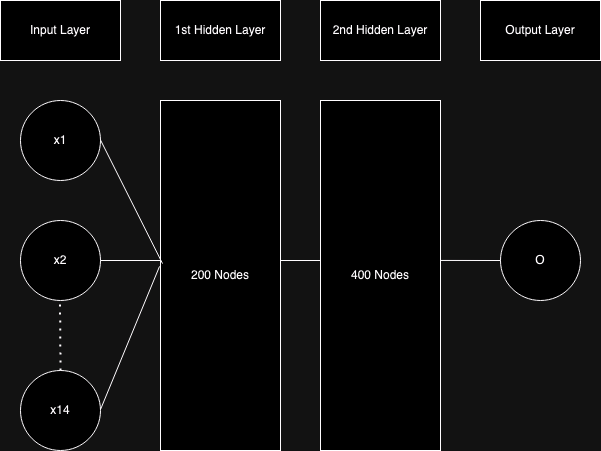

I wanted to try one more thing before changing the activation function again and that was to return to a single layer and increase its size, while also tuning the regularization parameter further.

In [313]:
# NN 4
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("nn", MLPRegressor(max_iter=5000, activation="tanh", hidden_layer_sizes = (400, ), solver="lbfgs", alpha=.995))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

In [314]:
y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

0.20579119275627367

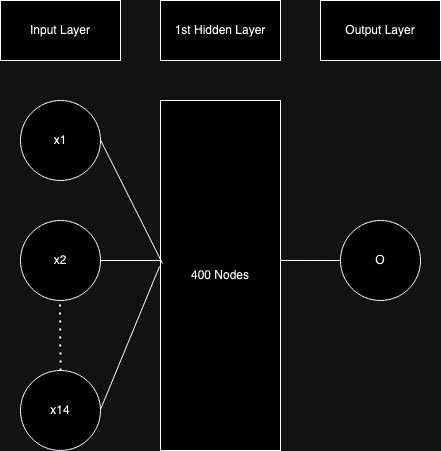

While the above step showed some promise, I still struggled to get an $R^2$ value above .21 using the tanh activation function. I am therefore going to try changing that feature one more time to attempt to improve performance and increasing the number of layers while decreasing the number of nodes.

In [384]:
# NN 5
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("nn", MLPRegressor(max_iter=10000, activation="identity", hidden_layer_sizes = (10, 10, 10, 6, ), solver="lbfgs", alpha = 1e-5))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

In [385]:
y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

0.23144553403968882

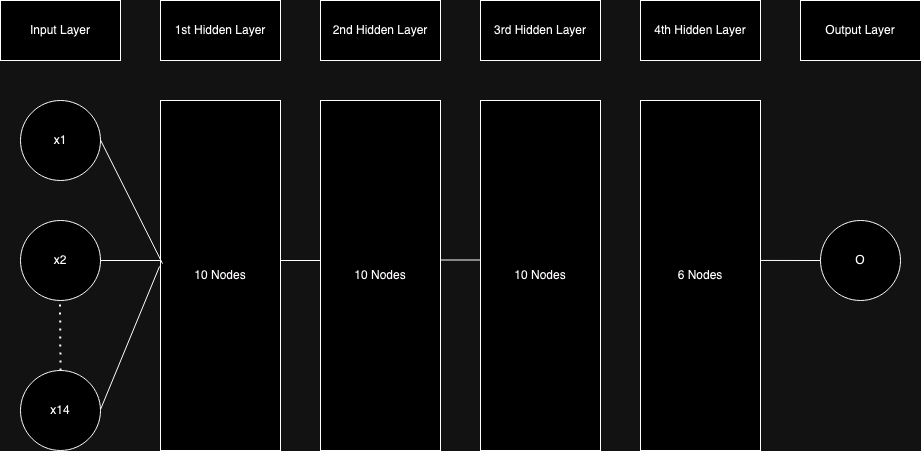

While an $R^2$ value of .23 is not great, it is the best that I was able to get from the neural network and a large step up from the -26 value I had at the beginning. Surprisingly, I found the identity activation function to provide the best and most reproducible results.

## Comparative Model - Random Forest

In [397]:
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("forest", RandomForestRegressor(n_jobs=-1))
    ]
)

parameters = {
    "forest__ccp_alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1],
    "forest__min_samples_leaf": [1, 2, 3, 4, 5, 10, 15, 25],
    "forest__min_samples_split": [2, 3, 4, 5, 10, 15, 25]
}

gscv = GridSearchCV(my_pipeline, parameters, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)
test_scores = gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(ccp_alpha=0.01, min_samples_leaf=10,
                                       min_samples_split=25, n_jobs=-1))])

In [399]:
my_pipeline = Pipeline(
    [
        # ("preprocessing", ct),
        ("forest", RandomForestRegressor(n_jobs=-1, ccp_alpha=.01, min_samples_leaf=10, min_samples_split=25))
    ]
)

fitted_pipeline = my_pipeline.fit(X_train, y_train)

y_pred = fitted_pipeline.predict(X_test)

r2_score(y_true = y_test, y_pred=y_pred)

0.23967069648889505

I find it very interesting that the random forest model appears to perform very similarly to the neural network. I was expecting the random forest to perform better than the neural network due to the decreased complexity and typically good performance of random forests.